<font color="#CC3D3D"><p>
# Build models

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

In [1]:
%%writefile word2vec.py

### Imports
import pandas as pd
import numpy as np
import os


### Read data
train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/test_transactions.csv', encoding='cp949')


### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습데이터가 부족하여 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

train_corpus = list(train.groupby('cust_id')[p_level].agg(oversample, 20))
test_corpus = list(test.groupby('cust_id')[p_level].agg(oversample, 20))


### Training the Word2Vec model
num_features = 100 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 2 # 학습 윈도우(인접한 단어 리스트) 크기


# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(train_corpus, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=0, workers=1)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)


### Make features
# 구매상품에 해당하는 벡터의 평균/최소/최대 벡터를 feature로 만드는 전처리기
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),                
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ]) 

# W2V 기반 feature 생성
train_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).fit(train_corpus).transform(train_corpus))
test_features = pd.DataFrame(EmbeddingVectorizer(w2v.wv).transform(test_corpus))

train_features.columns = ['v'+f'{c+1:03d}' for c in train_features.columns]
test_features.columns = ['v'+f'{c+1:03d}' for c in test_features.columns]

# 학습용과 제출용 데이터로 분리
pd.concat([pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}), train_features], axis=1).to_csv('../dat/X_train_w2v.csv', index=False)
pd.concat([pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}), test_features], axis=1).to_csv('../dat/X_test_w2v.csv', index=False)

Overwriting word2vec.py


In [2]:
import os
import subprocess

subprocess.run(['python', 'word2vec.py'], env={**os.environ, 'PYTHONHASHSEED': '123'})

CompletedProcess(args=['python', 'word2vec.py'], returncode=0)

##### Imports

In [3]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.base import ClassifierMixin
from gensim.models import word2vec


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [4]:
train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/test_transactions.csv', encoding='cp949')

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv(os.path.abspath("../dat")+'/y_train.csv', encoding='cp949').gender

In [5]:
train_w2v = pd.read_csv(os.path.abspath("../dat")+'/X_train_w2v.csv', encoding='cp949')
test_w2v = pd.read_csv(os.path.abspath("../dat")+'/X_test_w2v.csv', encoding='cp949')

In [6]:
features_w2v = pd.concat([train_w2v, test_w2v] ,axis=0).reset_index()

In [7]:
features_w2v

,index,cust_id,v001,v002,v003,v004,v005,v006,v007,v008,...,v391,v392,v393,v394,v395,v396,v397,v398,v399,v400
0,0,0,0.150334,0.265886,0.107195,0.161423,0.096694,0.240863,0.178099,0.207232,...,7.590713e-02,9.921508e-02,6.193848e-02,0.085719,8.474204e-02,0.059762,0.102060,9.026027e-02,0.071916,7.707719e-02
1,1,1,0.116861,-0.096285,0.130467,0.186913,-0.006893,-0.009479,0.014372,0.141896,...,1.281672e-02,5.271498e-02,1.661778e-02,0.056505,1.035643e-01,0.003572,0.017597,3.552838e-02,0.022831,7.137727e-02
2,2,2,0.150334,-0.002294,-0.019561,0.107281,-0.034426,0.029636,-0.004397,0.172880,...,5.414126e-02,9.340990e-02,6.691036e-02,0.002455,5.859699e-02,0.071063,0.107220,3.071417e-02,0.056627,7.849141e-03
3,3,3,0.150334,0.147990,0.242921,0.153904,0.043837,0.175834,0.213830,0.128871,...,4.744536e-02,8.794113e-02,6.536881e-02,0.083186,8.720368e-02,0.050332,0.095666,6.216948e-02,0.083897,7.980742e-02
4,4,4,0.150334,0.100967,0.017132,-0.007823,0.096694,0.023991,0.032221,0.128871,...,5.440820e-02,6.901445e-02,9.573746e-02,0.033898,6.891035e-02,0.015510,0.023073,3.678454e-02,0.026489,1.073092e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,2477,5977,0.150334,0.084762,-0.017967,0.229201,0.065777,0.240863,0.108917,0.167636,...,5.390976e-02,1.326901e-01,5.645293e-02,0.106711,5.471146e-02,0.103171,0.142208,3.381683e-02,0.082888,6.844767e-02
5978,2478,5978,0.060953,0.083050,0.046501,-0.089834,-0.050750,0.050216,0.041716,0.042240,...,7.450581e-09,1.490116e-08,7.450581e-09,0.000000,1.490116e-08,0.000000,0.000000,1.490116e-08,0.000000,2.980232e-08
5979,2479,5979,0.150334,0.186442,0.152917,0.205805,0.194752,0.240863,0.168427,0.233732,...,7.614885e-02,8.541006e-02,8.455273e-02,0.089853,1.058471e-01,0.085121,0.105142,6.792848e-02,0.100060,9.865241e-02
5980,2480,5980,0.140652,0.142205,0.071942,0.205805,0.201623,0.072100,0.192653,0.031818,...,3.987315e-02,8.506052e-02,6.717434e-02,0.113772,4.289752e-02,0.069749,0.073037,9.625312e-02,0.083763,9.125497e-02


In [8]:
features = features_w2v

*Select Features*

In [9]:
# 학습용과 제출용 데이터로 분리
test_id = test.cust_id.unique()
X_train = features.query('cust_id not in @test_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:21<00:00,  1.22it/s]


(97, 0.7442290643753411)


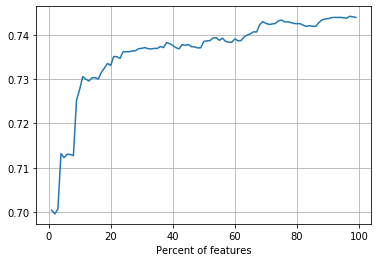

In [10]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

#StartifiedKFold 정의
sfk = StratifiedKFold(n_splits = 7)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = [] # 스코어를 저장할 리스트 생성
for p in tqdm(range(1,100,1)): # 추출할 피처의 개수 범위를 (1~100)%의 구간에서 1%씩 올려가며 실행
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=sfk).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [11]:
# 최고 Score 를 가지는 p값 적용 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 388)
['v001', 'v002', 'v003', 'v004', 'v005', 'v006', 'v007', 'v008', 'v009', 'v010', 'v011', 'v012', 'v013', 'v014', 'v015', 'v016', 'v017', 'v018', 'v019', 'v020', 'v021', 'v022', 'v023', 'v024', 'v025', 'v026', 'v027', 'v028', 'v029', 'v030', 'v031', 'v032', 'v033', 'v034', 'v035', 'v036', 'v037', 'v038', 'v039', 'v040', 'v041', 'v042', 'v043', 'v044', 'v045', 'v046', 'v047', 'v048', 'v049', 'v050', 'v051', 'v052', 'v053', 'v054', 'v055', 'v056', 'v057', 'v058', 'v059', 'v060', 'v061', 'v062', 'v063', 'v064', 'v065', 'v066', 'v067', 'v068', 'v069', 'v070', 'v071', 'v072', 'v073', 'v074', 'v075', 'v076', 'v077', 'v078', 'v079', 'v080', 'v081', 'v082', 'v083', 'v084', 'v085', 'v086', 'v087', 'v088', 'v089', 'v090', 'v091', 'v092', 'v093', 'v094', 'v095', 'v096', 'v097', 'v098', 'v099', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v107', 'v108', 'v109', 'v110', 'v111', 'v112', 'v113', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v1

### 5. Model Tuning (Hyperparameter Optimization)

In [12]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
# stratify=y_train 를 통해 데이터를 분할할 때 층화추출을 실시(불균형을 해소한다.)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [13]:
clfs = [
#    (
#        KNeighborsClassifier(),              # KNN모델 사용
#        {'n_neighbors': range(1,51),        
#         'weights': ['uniform','distance'],
#         'metric': ['minkowski', 'euclidean', 'manhattan']}
#    ),
#    (
#       DecisionTreeClassifier(random_state=0), # 의사결정나무모델 사용
#       {'max_depth' : [2,3,4,5,6,7,8,9,10]} # 트리의 최대 깊이를 2,3 중 하나 선택
#    ),
    (
        XGBClassifier(random_state=0), # 외부 패키지인 XGBClassifier 사용
        {'max_depth': range(1, 10, 1),
         'n_estimators': range(100, 500, 100),
         'learning_rate': np.arange(0.01, 1, 0.01),
         'eta': [0, 0.5, 0.01],
         'gamma' :np.arange(0.01,5,0.01),
         'subsample': [0.2, 0.3, 0.5, 0.7, 0.9, 1],
         'colsample_bytree': [0.5, 0.7, 0.9, 1]}
    ),
    (
        AdaBoostClassifier(random_state=0), # AdaBoosr 사용(약한 학습기의 오류 데이터에 가중치를 부여하며 부스팅수행)
        {'n_estimators' : [50,100,500,1000,3000], # 생성할 약한 학습기의 개수와 학습률의 범위 그리고 알고리즘을 지정
         'learning_rate' : np.arange(0.1, 1, 0.1), 
         'algorithm' : ['SAMME', 'SAMME.R']}
    ),
    (
        MLPClassifier(random_state=0), # Neural network 분류기 사용
        {'batch_size': ['auto', 32, 64, 128], # 최적화 학습의 최소크기와 , 학습률, 가중치최적화solver 등을 설정
         'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         'activation': ['tanh', 'relu', 'logistic'],
         'solver': ['sgd', 'adam'],
         'alpha' : [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9], 
         'hidden_layer_sizes': [(32,),(64,),(128,),(32,16),(64,32,16)]}
    ),
    (
        LogisticRegression(random_state=0), # LogisticRegression 모델사용
        {'C': np.arange(0.1, 10, 0.1), # 패널티, 정규화 강도 범위 설정
         'penalty': ['l1','l2']}
    ),
#    (
#        RandomForestClassifier(random_state=0), # Begging을 이용한 앙상블모델 RandomForestClassifier 사용
#        {'n_estimators': range(10, 500, 10), # 생성할 트리의 개수와 트리의 깊이 전체 피처개수의 범위를 설정
#         'max_depth': [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
#         'max_features': ['auto', 'sqrt', 'log2'], 
#         'bootstrap': [True, False], 
#         'criterion': ['gini', 'entropy'], 
#         'class_weight': ['balanced', 'balanced_subsample', {}], 
#         'min_samples_split': [2, 5, 7, 9, 10], 
#         'min_samples_leaf': [2, 3, 4, 5, 6]}
#    ),
    (
        GradientBoostingClassifier(random_state=0), # Gradient Boost Machine 사용
        {'n_estimators': range(10, 500, 10), # 생성할 트리의 개수와 학습률, 분할을 위한 feature의 최대 개수 설정
         'learning_rate': [0.01, 0.5, 0.001],
         'min_samples_split': [2, 4, 5, 7, 9, 10],
         'min_samples_leaf': [1, 2, 3, 4, 5],
         'max_depth': [1,2,3,4,5,6,7,8,9,10,11],
         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
         'max_features': ['auto', 'sqrt', 'log2']}
    ),
#    (
#        SVC(probability = True), # Surpport vector machine 사용
#        {'kernel' : ["linear"], # 알고리즘에 사용할 kernel 유형, 오류허용치범위, 민감도범위를 설정
#         'C' : np.arange(0.01, 5, 0.01),
#         'gamma' : np.arange(0.5, 10, 0.1)}
#    ),
#    (
#        ExtraTreesClassifier(random_state=0),
#       {'n_estimators': [100,200,300,400],
#         'max_depth': [1,2,3,4,5,6,7,8,9,10]}
#    ),
#    (
#        LGBMClassifier(random_state=0),
#        {'n_estimators': [100,200,300,400],
#         'learning_rate': [0.01,1,0.01],
#         'max_depth': [1,2,3,4,5]}
#    )
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    clf_name = type(clf).__name__
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=30, scoring='roc_auc', 
                                     cv=sfk, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 20%|████████████████                                                                | 1/5 [17:05<1:08:23, 1025.94s/it]

XGBClassifier                                        0.780769 1025.9


 40%|███████████████████████████████▏                                              | 2/5 [1:47:13<1:57:01, 2340.36s/it]

AdaBoostClassifier                                   0.778887 5407.3


 60%|██████████████████████████████████████████████▊                               | 3/5 [1:58:57<1:01:38, 1849.46s/it]

MLPClassifier                                        0.767120 704.0


 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:59:08<21:38, 1298.01s/it]

LogisticRegression                                   0.766319 11.3


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:40:05<00:00, 1921.11s/it]

GradientBoostingClassifier                           0.777735 2457.0


### 6. Model Ensemble

*Correlation between models*

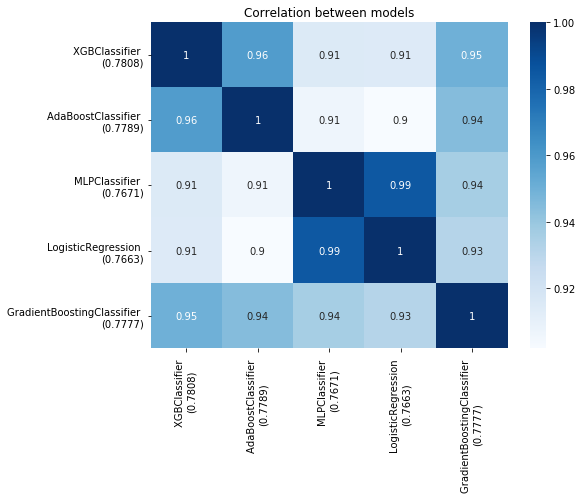

In [14]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

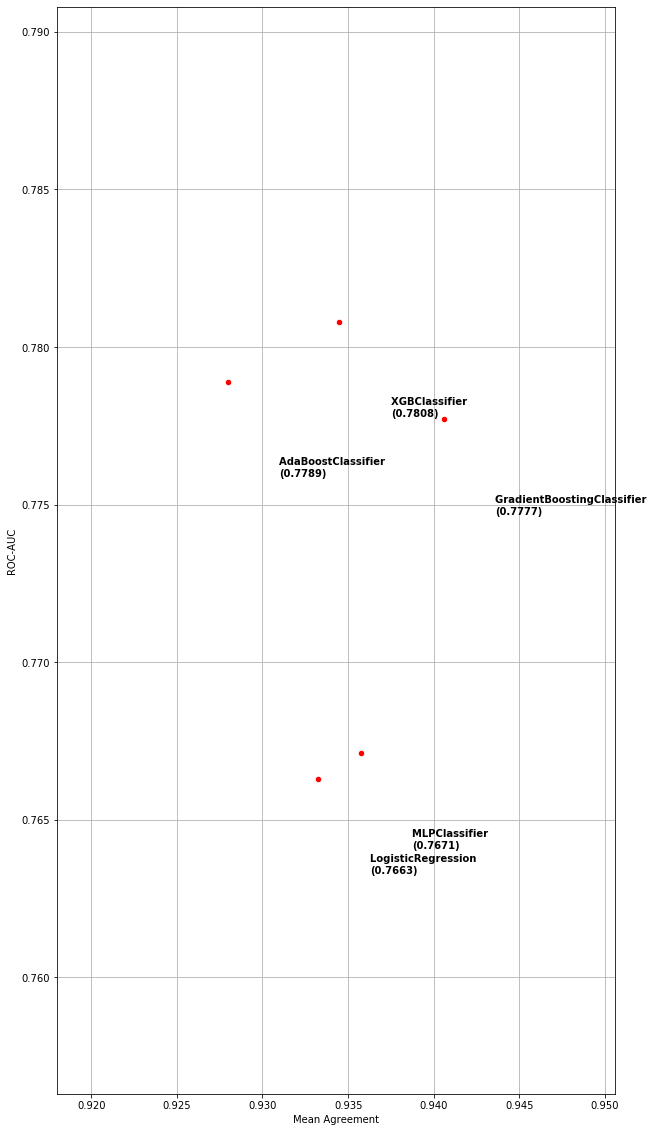

In [15]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(10,20))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

In [16]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

XGBClassifier \n(0.7808)                 0.934492
AdaBoostClassifier \n(0.7789)            0.927992
MLPClassifier \n(0.7671)                 0.935740
LogisticRegression \n(0.7663)            0.933263
GradientBoostingClassifier \n(0.7777)    0.940572
dtype: float64

*Averaging Ensemble*

In [17]:
# 모델 개별 Score와 모델 간 상관관계를 고려하여 Averaging 앙상블에 사용하지 않을 모델은 주석 처리
selected = [
#    'KNeighborsClassifier',
#    'DecisionTreeClassifier'
    'XGBClassifier',
    'AdaBoostClassifier',
    'MLPClassifier',
    'LogisticRegression', 
#    'RandomForestClassifier',
    'GradientBoostingClassifier',
#    'SVC',
#    'ExtraTreesClassifier',
#    'LGBMClassifier'
]

models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [22]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.05s/it]

p=2.56
XGBClassifier●AdaBoostClassifier●GradientBoostingClassifier
0.7849357425838245


In [23]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in self.estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

### 7. Deployment

In [24]:
# Averaging ensemble을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('../dat/submissions1/W2V_ave.csv', index=False)
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('../dat/submissions2/W2V_ave.csv', index=False)

<font color="#CC3D3D"><p>
# End